In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('../raw_data/train.csv')
test_df = pd.read_csv('../raw_data/test.csv')
submission_df = pd.read_csv('../raw_data/sample_submission.csv')

In [32]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


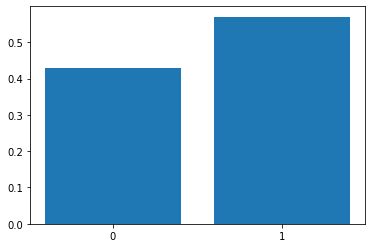

In [30]:
plt.bar(train_df['target'].unique(),train_df['target'].value_counts()/len(train_df))
plt.xticks(ticks=train_df['target'].unique())
plt.show()

Target classes are slightly imbalanced, but shouldn't be a problem.

### Preprocessing

#### Basic for all types of data

In [35]:
train_df.isnull().sum()/len(train_df)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

First model won't use location. Given that there are less than 1% of tweets missing keyword, I'll drop the rows with NaNs in that column

In [44]:
train_df = train_df[train_df['keyword'].notna()]

In [38]:
len(train_df.drop_duplicates()) == len(train_df)

True

No duplicates found

In [53]:
X_train = train_df.drop(columns=['target','location'])
y_train = train_df['target']

#### Basic for text

Create custom transformer for basic text preprocessing. Easier to play around later on.

In [55]:
def remove_digits(string):
    """Remove digits from the given string"""
    return ''.join(letter for letter in string if not letter.isdigit())

In [66]:
from nltk.tokenize import word_tokenize

def tokenize(string):
    """Returns list of words componing the string"""
    return word_tokenize(string)

def detokenize(tokenized_string):
    return ' '.join(tokenized_string)

In [64]:
def remove_stopwords(tokenized_string, stopwords):
    """Given a list of words, removes all words that are in stopwords"""
    return [word for word in tokenized_string if word not in stopwords]

In [65]:
from nltk.stem import WordNetLemmatizer

def lemmatize(tokenized_string):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokenized_string]

In [102]:
from sklearn.base import TransformerMixin, BaseEstimator
import string
from nltk.corpus import stopwords

class BasicTextProcessor(TransformerMixin, BaseEstimator):
    """
    Transformer that gets fed pd.Series containing text. Can be defined which actions should be executed:
    - lower
    - remove digits
    - exclude certain types of punctuation (everything else will be removed)
    - exclude certain stopwords (everything else will be removed)
    - lemmatize
    """
    def __init__(self, lower=True, remove_num=True, excl_punct=None, excl_stopwords=None, lemmatize=True):
        self.lower = lower
        self.remove_num = remove_num
        self.excl_punct = excl_punct
        self.excl_stopwords = excl_stopwords
        self.lemmatize = lemmatize
    
    def fit(self, X, y=None):
        if self.excl_punct:
            self.punctuation = ''.join(i for i in string.punctuation if i not in self.excl_punct)
        else:
            self.punctuation = string.punctuation
        if self.excl_stopwords:
            self.stopwords = [i for i in stopwords.words("english") if i not in self.excl_stopwords]
        else:
            self.stopwords = stopwords.words("english")
        
        return self
    
    def transform(self, X, y=None):
        X_transformed = X['text'].copy()
        
        if self.lower:
            X_transformed = X_transformed.str.lower()
        if self.remove_num:
            X_transformed = X_transformed.apply(remove_digits)
        
        # substitute ' with space for better removal of stopwords
        if "'" in self.punctuation:
            X_transformed = X_transformed.str.replace("'",' ',regex=False)
        for punct in self.punctuation:
            X_transformed = X_transformed.str.replace(punct,'',regex=False)
        
        # actions on tokenized string
        X_transformed_tokenized = X_transformed.apply(tokenize)
        X_transformed_tokenized = X_transformed_tokenized.apply(remove_stopwords,stopwords=self.stopwords)
        X_transformed_tokenized = X_transformed_tokenized.apply(lemmatize)
        
        return X_transformed_tokenized.apply(detokenize)

#### Vectorize

In [103]:
# bag of words for keyword column, tfidf for text column

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

bow = CountVectorizer()
tfidf = TfidfVectorizer()

#### Build pipeline

In [104]:
from sklearn import set_config
set_config(display="diagram")

In [105]:
from sklearn.pipeline import Pipeline

tweet_pipe = Pipeline([
    ('basic', BasicTextProcessor()),
    ('vectorize', tfidf)
])

In [112]:
from sklearn.compose import ColumnTransformer

preproc_pipe = ColumnTransformer([
    ('tweets', tweet_pipe,['text']),
    ('keywords', bow, 'keyword')
],sparse_threshold=0)

preproc_pipe

ColumnTransformer(sparse_threshold=0,
                  transformers=[('tweets',
                                 Pipeline(steps=[('basic',
                                                  BasicTextProcessor()),
                                                 ('vectorize',
                                                  TfidfVectorizer())]),
                                 ['text']),
                                ('keywords', CountVectorizer(), 'keyword')])

In [115]:
preproc_pipe.fit_transform(X_train)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

#### Feature engineering?

In [ ]:
# could be number of punctuation